1. Bahdanau注意力
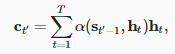
2. 一个带有Bahdanau注意力的循环神经网络编码器-解码器模型
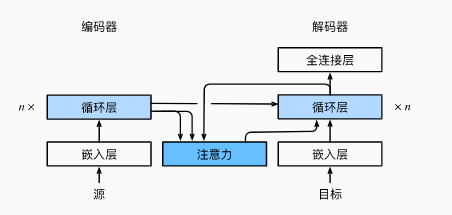


In [1]:
import torch
from torch import nn
import dltools

In [2]:
# 定义注意力解码器
class AttentionDecoder(dltools.Decoder):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
    @property
    def attention_weights(self):
        raise NotImplementedError

In [13]:
# 添加Bahdanau的decoder
class Seq2SeqAttentionDecoder(AttentionDecoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0, **kwargs):
        super().__init__(**kwargs)
        self.attention = dltools.AdditiveAttention(num_hiddens, num_hiddens, num_hiddens, dropout)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size + num_hiddens, num_hiddens, num_layers, dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)
        
    def init_state(self, enc_outputs, enc_valid_lens, *args):
        # outputs : (batch_size, num_steps, num_hiddens)
        # hidden_state: (num_layers, batch_size, num_hiddens)
        outputs, hidden_state = enc_outputs
        return (outputs.permute(1, 0, 2), hidden_state, enc_valid_lens)
    
    def forward(self, X, state):
        # enc_outputs (batch_size, num_steps, num_hiddens)
        # hidden_state: (num_layers, batch_size, num_hiddens)
        enc_outputs, hidden_state, enc_valid_lens = state
        # X : (batch_size, num_steps, vocab_size)
        X = self.embedding(X) # X : (batch_size, num_steps, embed_size)
        X = X.permute(1, 0, 2)
        outputs, self._attention_weights = [], []
        
        for x in X:
            query = torch.unsqueeze(hidden_state[-1], dim=1) # batch_size, 1, num_hiddens
            print('query:', query.shape) # 4, 1, 16
            context = self.attention(query, enc_outputs, enc_outputs, enc_valid_lens)
            print('context: ', context.shape)
            x = torch.cat((context, torch.unsqueeze(x, dim=1)), dim=-1)
            print('x: ', x.shape)
            out, hidden_state = self.rnn(x.permute(1, 0, 2), hidden_state)
            print('out:', out.shape)
            print('hidden_state:', hidden_state.shape)
            outputs.append(out)
            self._attention_weights.append(self.attention_weights)
            
        print('---------------------------------')
        outputs = self.dense(torch.cat(outputs, dim=0))
        print('解码器最终输出形状: ', outputs.shape)
        return outputs.permute(1, 0, 2), [enc_outputs, hidden_state, enc_valid_lens]
    
    @property
    def attention_weights(self):
        return self._attention_weights

In [14]:
encoder = dltools.Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16, num_layers=2)
encoder.eval()
decoder = Seq2SeqAttentionDecoder(vocab_size=10, embed_size=8, num_hiddens=16, num_layers=2)
decoder.eval()

# batch_size 4, num_steps 7
X = torch.zeros((4, 7), dtype=torch.long)
state = decoder.init_state(encoder(X), None)
output, state = decoder(X, state)
output.shape, len(state), state[0].shape, len(state[1]), state[1][0].shape

query: torch.Size([4, 1, 16])
context:  torch.Size([4, 1, 16])
x:  torch.Size([4, 1, 24])
out: torch.Size([1, 4, 16])
hidden_state: torch.Size([2, 4, 16])
query: torch.Size([4, 1, 16])
context:  torch.Size([4, 1, 16])
x:  torch.Size([4, 1, 24])
out: torch.Size([1, 4, 16])
hidden_state: torch.Size([2, 4, 16])
query: torch.Size([4, 1, 16])
context:  torch.Size([4, 1, 16])
x:  torch.Size([4, 1, 24])
out: torch.Size([1, 4, 16])
hidden_state: torch.Size([2, 4, 16])
query: torch.Size([4, 1, 16])
context:  torch.Size([4, 1, 16])
x:  torch.Size([4, 1, 24])
out: torch.Size([1, 4, 16])
hidden_state: torch.Size([2, 4, 16])
query: torch.Size([4, 1, 16])
context:  torch.Size([4, 1, 16])
x:  torch.Size([4, 1, 24])
out: torch.Size([1, 4, 16])
hidden_state: torch.Size([2, 4, 16])
query: torch.Size([4, 1, 16])
context:  torch.Size([4, 1, 16])
x:  torch.Size([4, 1, 24])
out: torch.Size([1, 4, 16])
hidden_state: torch.Size([2, 4, 16])
query: torch.Size([4, 1, 16])
context:  torch.Size([4, 1, 16])
x:  tor

(torch.Size([4, 7, 10]), 3, torch.Size([4, 7, 16]), 2, torch.Size([4, 16]))

loss 0.020, 7156.7 tokens/sec on cuda:0


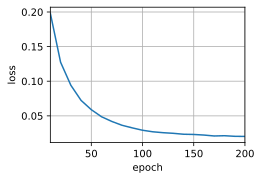

In [17]:
# 训练
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 200, dltools.try_gpu()

train_iter, src_vocab, tgt_vocab = dltools.load_data_nmt(batch_size, num_steps)

encoder = dltools.Seq2SeqEncoder(len(src_vocab), embed_size, num_hiddens, num_layers, dropout)

decoder = Seq2SeqAttentionDecoder(len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)

net = dltools.EncoderDecoder(encoder, decoder)

dltools.train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

In [21]:
def bleu(pred_seq, label_seq, k):
    print('pred_seq', pred_seq)
    print('label_seq:', label_seq)
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1 - (len_label / len_pred)))
    for n in range(1, k + 1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1):
            label_subs[' '.join(label_tokens[i: i + n])] += 1
            
        for i in range(len_pred - n + 1):
            if label_subs[' '.join(pred_tokens[i: i + n])] > 0:
                num_matches += 1
                label_subs[' '.join(pred_tokens[i: i + n])] -= 1
        score *=  math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))   
    return score

In [24]:
import math

In [26]:
import collections

In [27]:
# 开始预测
engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation = dltools.predict_seq2seq(net, eng, src_vocab, tgt_vocab, num_steps, device)
    print(f'{eng} => {translation}, bleu {dltools.bleu(translation[0], fra, k=2):.3f}')

query: torch.Size([1, 1, 32])
context:  torch.Size([1, 1, 32])
x:  torch.Size([1, 1, 64])
out: torch.Size([1, 1, 32])
hidden_state: torch.Size([2, 1, 32])
---------------------------------
解码器最终输出形状:  torch.Size([1, 1, 201])
query: torch.Size([1, 1, 32])
context:  torch.Size([1, 1, 32])
x:  torch.Size([1, 1, 64])
out: torch.Size([1, 1, 32])
hidden_state: torch.Size([2, 1, 32])
---------------------------------
解码器最终输出形状:  torch.Size([1, 1, 201])
query: torch.Size([1, 1, 32])
context:  torch.Size([1, 1, 32])
x:  torch.Size([1, 1, 64])
out: torch.Size([1, 1, 32])
hidden_state: torch.Size([2, 1, 32])
---------------------------------
解码器最终输出形状:  torch.Size([1, 1, 201])
go . => ('va !', []), bleu 1.000
query: torch.Size([1, 1, 32])
context:  torch.Size([1, 1, 32])
x:  torch.Size([1, 1, 64])
out: torch.Size([1, 1, 32])
hidden_state: torch.Size([2, 1, 32])
---------------------------------
解码器最终输出形状:  torch.Size([1, 1, 201])
query: torch.Size([1, 1, 32])
context:  torch.Size([1, 1, 32])
x:  